In [664]:
import numpy as np
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
%matplotlib inline
plt.rcParams['figure.figsize'] = 15,10
import pandas as pd
from sklearn.utils import shuffle
from pylab import savefig
from sklearn.tree import DecisionTreeClassifier


class AccuracyHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.acc = []

    def on_epoch_end(self, batch, logs={}):
        self.acc.append(logs.get('acc'))


import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.utils import np_utils



In [105]:
# Read all the data in
players = pd.read_json('profiles.json')
games = pd.read_json('games.json')

In [665]:
hof = pd.read_csv('hof.csv').rename(columns={'From': 'year', 'To': 'end_year', 'Player': 'name'})[['name', 'Indct', 'year', 'end_year']]
hof.head(2)

,name,Indct,year,end_year
0,Robert Brazile,2018,1975,1984
1,Brian Dawkins,2018,1996,2011


# Data Inspection and Cleaning

In [666]:
data = games.merge(players, on = 'player_id', how='outer') # merge in player data
# data_hof = data.merge(hof, on='name', how='left') # merge in hof status
data_d = data.drop(columns=[
    'date',
    'game_location',
    'game_number',
    'opponent',
    'opponent_score',
    'player_team_score',
    'passing_rating',
    'birth_date',
    'birth_place',
    'current_salary',
    'current_team',
    'death_date',
    'draft_team',
    'draft_year', 
    'height', 
    'weight',
    'hof_induction_year'
])



In [668]:
data_d.head(2)

,age,defense_interception_touchdowns,defense_interception_yards,defense_interceptions,defense_sacks,defense_safeties,defense_tackle_assists,defense_tackles,field_goal_attempts,field_goal_makes,...,rushing_touchdowns,rushing_yards,team,year,college,draft_position,draft_round,high_school,name,position
0,23-120,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,SEA,1990.0,Baylor,34.0,2.0,"Van Vleck, TX",Robert Blackmon,DB
1,23-127,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,SEA,1990.0,Baylor,34.0,2.0,"Van Vleck, TX",Robert Blackmon,DB


In [670]:
data_f = data_d.fillna(0)

#data_c.loc[data_c['name'] == 'Jerry Rice']# cut out a lot of data for getting pipeline set-up
data_f['end_year'] = data_f['year']
data_p = data_f.set_index('player_id')
data_p.head(3)

,age,defense_interception_touchdowns,defense_interception_yards,defense_interceptions,defense_sacks,defense_safeties,defense_tackle_assists,defense_tackles,field_goal_attempts,field_goal_makes,...,rushing_yards,team,year,college,draft_position,draft_round,high_school,name,position,end_year
player_id,,,,,,,,,,,,,,,,,,,,,
1809,23-120,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,SEA,1990.0,Baylor,34.0,2.0,"Van Vleck, TX",Robert Blackmon,DB,1990.0
1809,23-127,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,SEA,1990.0,Baylor,34.0,2.0,"Van Vleck, TX",Robert Blackmon,DB,1990.0
1809,23-134,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,SEA,1990.0,Baylor,34.0,2.0,"Van Vleck, TX",Robert Blackmon,DB,1990.0


In [673]:
# grouped = data_d.set_index(['player_id','name']).groupby(['player_id','name']) # groups all player games together
grouped = data_p.groupby(['player_id']) # groups all player games together

In [674]:
grouped.count().sort_values(by=['age'], ascending=[0]).head(5) # counts total number of games per player


,age,defense_interception_touchdowns,defense_interception_yards,defense_interceptions,defense_sacks,defense_safeties,defense_tackle_assists,defense_tackles,field_goal_attempts,field_goal_makes,...,rushing_yards,team,year,college,draft_position,draft_round,high_school,name,position,end_year
player_id,,,,,,,,,,,,,,,,,,,,,
399,393,393,393,393,393,393,393,393,393,393,...,393,393,393,393,393,393,393,393,393,393
448,376,376,376,376,376,376,376,376,376,376,...,376,376,376,376,376,376,376,376,376,376
22951,375,375,375,375,375,375,375,375,375,375,...,375,375,375,375,375,375,375,375,375,375
6755,363,363,363,363,363,363,363,363,363,363,...,363,363,363,363,363,363,363,363,363,363
8989,333,333,333,333,333,333,333,333,333,333,...,333,333,333,333,333,333,333,333,333,333


In [675]:
agg_data = grouped.agg({
    'name': ['first'],
    'age': ['max'], 
    'year': ['min'], 
    'end_year': ['max'], 
    'defense_interception_touchdowns': ['sum'], 
    'defense_interception_yards': ['sum'],
    'defense_interceptions': ['sum'],
    'defense_sacks': ['sum'], 
    'defense_safeties': ['sum'],
    'defense_tackle_assists': ['sum'], 
    'defense_tackles': ['sum'],
    'field_goal_attempts': ['sum'],
    'field_goal_makes': ['sum'],
    'game_won': ['sum'], 
    'kick_return_attempts': ['sum'],
    'kick_return_touchdowns': ['sum'],
    'kick_return_yards': ['sum'],
    'passing_attempts': ['sum'],
    'passing_completions': ['sum'], 
    'passing_interceptions': ['sum'], 
    'passing_sacks': ['sum'], 
    'passing_sacks_yards_lost': ['sum'], 
    'passing_touchdowns': ['sum'],
    'passing_yards': ['sum'],
    'point_after_attemps': ['sum'],
    'point_after_makes': ['sum'],
    'punt_return_attempts': ['sum'], 
    'punt_return_touchdowns': ['sum'],
    'punt_return_yards': ['sum'], 
    'punting_attempts': ['sum'],
    'punting_blocked': ['sum'],
    'punting_yards': ['sum'], 
    'receiving_receptions': ['sum'], 
    'receiving_targets': ['sum'],
    'receiving_touchdowns': ['sum'], 
    'receiving_yards': ['sum'],
    'rushing_attempts': ['sum'],
    'rushing_touchdowns': ['sum'], 
    'rushing_yards': ['sum'],
   # 'team': [lambda x:x.value_counts().index[0]], # most frequent
   # 'college': [lambda x:x.value_counts().index[0]], # most frequent
    'draft_position': ['first'],
    'draft_round': ['first'], #TODO watch comma
    #'high_school': [lambda x:x.value_counts().index[0]], # most frequent
    'position': ['first'] # most frequent
    
})

In [676]:
agg_data.columns = agg_data.columns.get_level_values(0) # resets columns / flattens columns

In [725]:
noms = pd.read_csv('noms.csv')
noms_id = noms.merge(agg_data.reset_index(), on=['name', 'year', 'end_year'], how='left').set_index(['player_id'])
noms_id['years_played'] = noms_id['end_year'] - noms_id['year'] + 1
noms_id = noms_id.fillna(0)
noms_id = noms_id.drop(columns=['name','age','year','end_year','position','years_played']).reset_index()
# df.loc[df['column_name'].isin(some_values)]
noms_id = noms_id.loc[noms_id['player_id'].isin([2782,10156.0,23246.0])].drop(columns=['player_id'])
# noms_id2 = noms_id[noms_id['player_id'] == 10156.0]
# noms_id3 = noms_id[noms_id['player_id'] == 23246.0]
# noms_id = pd.concat([noms_id1, noms_id2, noms_id3], axis=1)
# #identify 3 wr nominees above

data_hof = agg_data.reset_index().merge(hof, on=['name','year', 'end_year'], how='left') # merge in hof status
data_hof['years_played'] = data_hof['end_year'] - data_hof['year'] + 1
data_hof = data_hof.fillna(0)

#noms_id  # the three WR nominees for HOF class of 2019

In [679]:
data_hof['is_hof'] = np.where(data_hof['Indct']==0, 0, 1) # sets the Hall of Fame indicator


In [682]:
data_cut = data_hof[data_hof['years_played'] >= 5]
#data_cut.head(4)
#data_cut.groupby(['is_hof', 'position']).count().sort_values(by=['is_hof','age'], ascending=[0,0])

In [683]:
# Select anyone with a position tag and put them in the respective position group.
qb_data = data_cut[data_cut['position'].str.contains('QB')]
rb_data = data_cut[data_cut['position'].str.contains('RB')]
wr_data = data_cut[data_cut['position'].str.contains('WR')]

# Validate that anyone with a tag is in the group
# qb_data.groupby('position').count()
# rb_data.groupby('position').count()
# wr_data.groupby('position').count()


In [684]:
# Filter datasets to get rid of accidental additions to position group.
qb_data_clean1 = qb_data[qb_data['passing_yards'] > 2000]
rb_data_clean1 = rb_data[rb_data['rushing_yards'] > 500]
wr_data_clean1 = wr_data[wr_data['receiving_yards'] > 500]
#qb_data_clean[['passing_yards']].sort_values(by=['passing_yards'], ascending=[1]) # verify filter is working


# clean out players who are potentially great, but are playing too soon to be eligible for HOF
qb_data_clean = qb_data_clean1[qb_data_clean1['end_year']<2012]
rb_data_clean = rb_data_clean1[rb_data_clean1['end_year']<2012]
wr_data_clean = wr_data_clean1[wr_data_clean1['end_year']<2012]

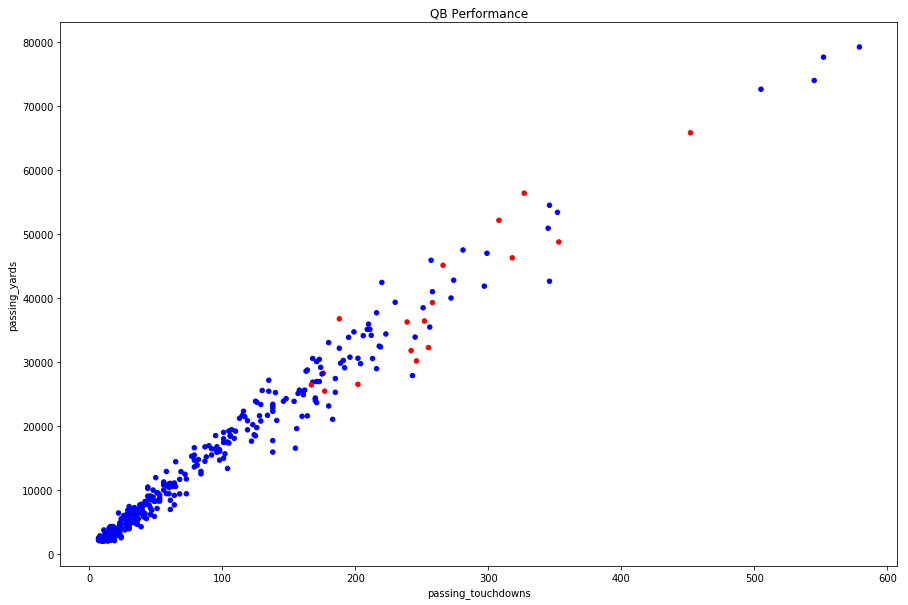

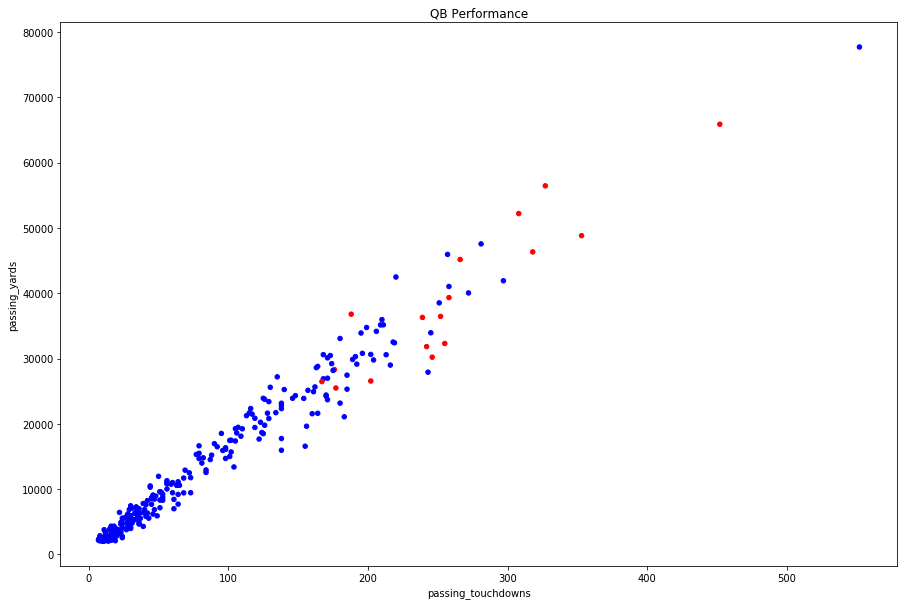

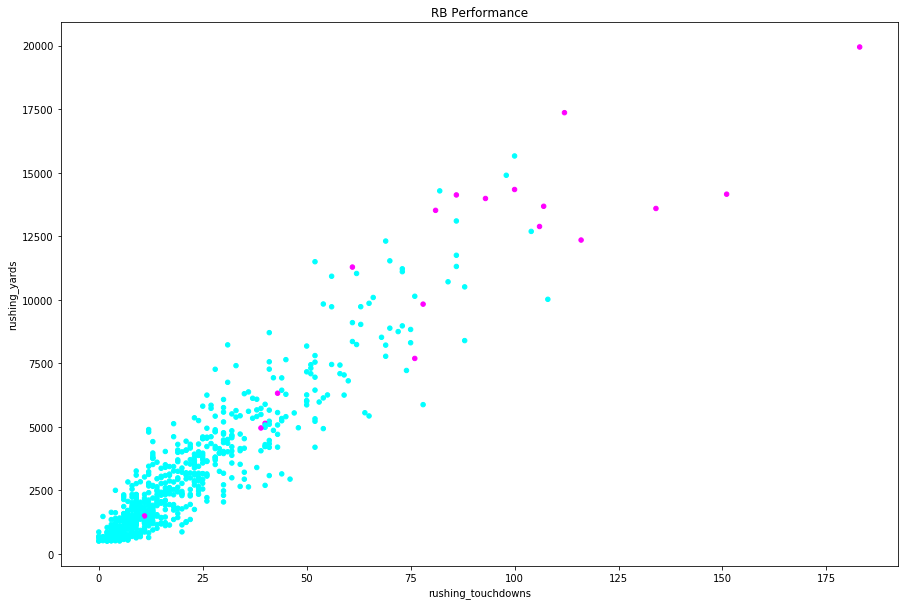

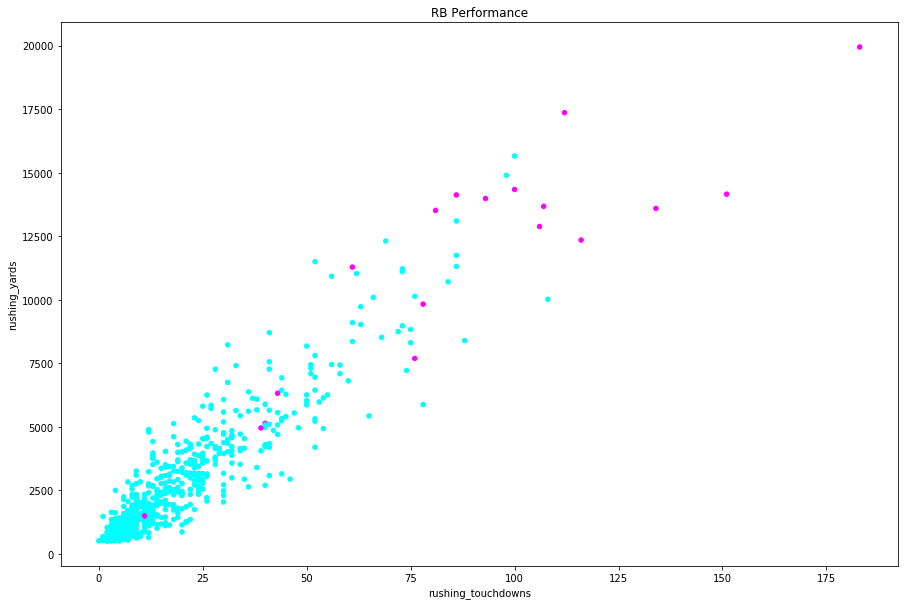

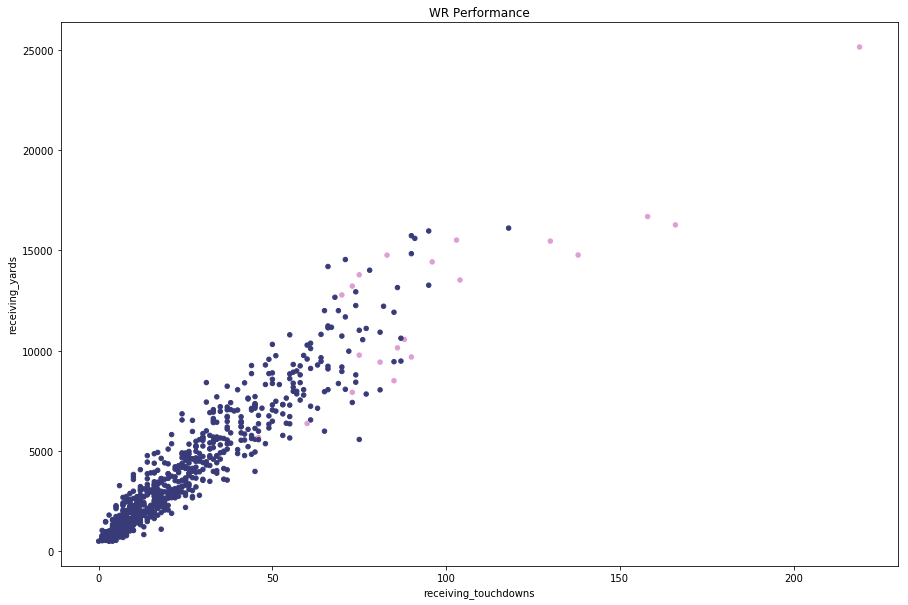

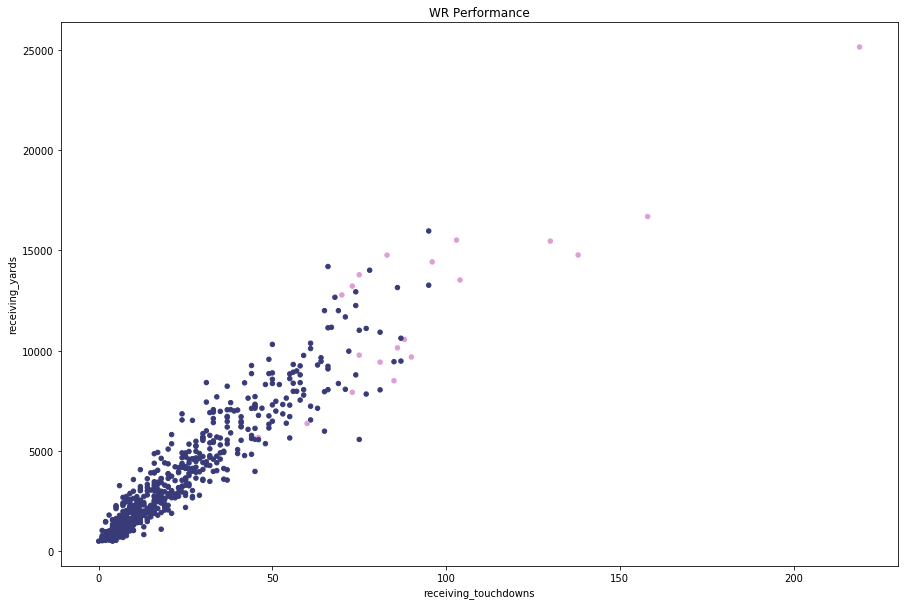

In [685]:
qb_data_clean1.plot.scatter(x='passing_touchdowns', y='passing_yards', c='is_hof', colormap='bwr', colorbar=False, title='QB Performance')
savefig('qb_dirty.png', bbox_inches='tight')
qb_data_clean.plot.scatter(x='passing_touchdowns', y='passing_yards', c='is_hof', colormap='bwr', colorbar=False, title='QB Performance')
savefig('qb.png', bbox_inches='tight')


rb_data_clean1.plot.scatter(x='rushing_touchdowns', y='rushing_yards', c='is_hof', colormap='cool', colorbar=False, title='RB Performance')
savefig('rb_dirty.png', bbox_inches='tight')
rb_data_clean.plot.scatter(x='rushing_touchdowns', y='rushing_yards', c='is_hof', colormap='cool', colorbar=False, title='RB Performance')
savefig('rb.png', bbox_inches='tight')


wr_data_clean1.plot.scatter(x='receiving_touchdowns', y='receiving_yards', c='is_hof', colormap='tab20b', colorbar=False, title='WR Performance')
savefig('wr_dirty.png', bbox_inches='tight')
wr_data_clean.plot.scatter(x='receiving_touchdowns', y='receiving_yards', c='is_hof', colormap='tab20b', colorbar=False, title='WR Performance')
savefig('wr.png', bbox_inches='tight')



# Modeling 

 ### QB model

In [711]:

# Getting the training and test sets
qb_X = qb_data_clean.drop(columns=['is_hof', 'Indct'])
# 'team','college','high_school'
qb_X = qb_X.drop(columns=['name','age','year','end_year','position','years_played']).set_index('player_id')
qb_y = qb_data_clean.set_index('player_id')['is_hof']

#qbX_train, qbX_test, qby_train, qby_test = train_test_split(qb_X, qb_y, test_size=0.4)
#qbX_hof = 

qb_HOF = shuffle(qb_data_clean[qb_data_clean['is_hof']==1])
qb_HOFn = shuffle(qb_data_clean[qb_data_clean['is_hof']==0])

# 17/ 338 QBs are HOF. About 5% population
qb_hof_train = qb_HOF.head(14)
qb_hof_test = qb_HOF.tail(3)
qb_train = shuffle(pd.concat([qb_hof_train, qb_HOFn.head(14)]))
qb_test = shuffle(pd.concat([qb_hof_test, qb_HOFn.tail(57)])) # the 3 test QBs are 5% of 60 so: (60 - 3)

qbX_train = qb_train.drop(columns=['name','age','year','end_year','position','years_played','is_hof', 'Indct']).set_index('player_id')
qby_train = qb_train.set_index('player_id')['is_hof']

qbX_test = qb_test.drop(columns=['name','age','year','end_year','position','years_played','is_hof', 'Indct']).set_index('player_id')
qby_test = qb_test.set_index('player_id')['is_hof']


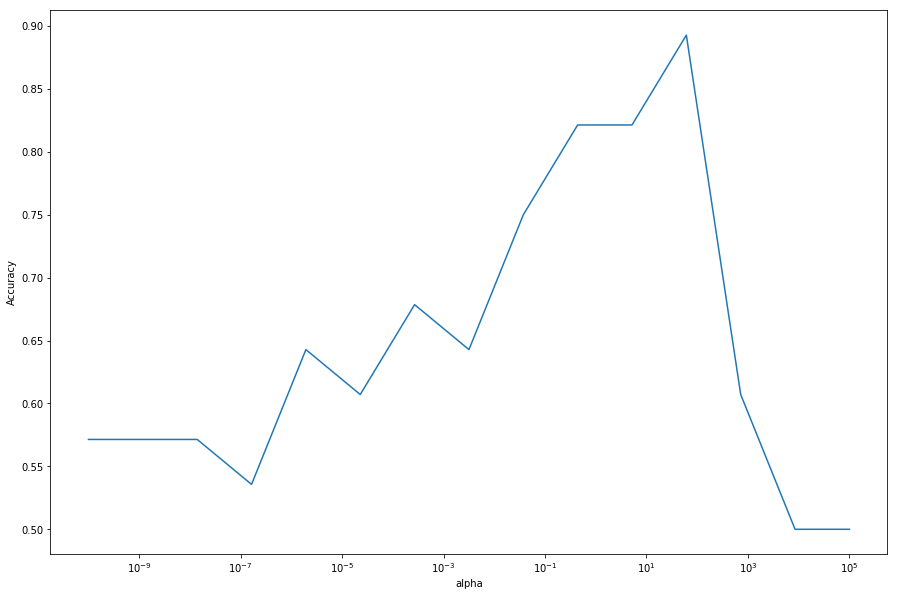

Best alpha:  61.05402296585314
Theta found by sklearn:  [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  8.17407325e-07 -3.24075608e-05
   0.00000000e+00 -9.21168539e-03  0.00000000e+00  0.00000000e+00
   0.00000000e+00  1.32483394e-02 -5.08626101e-02 -1.21367380e-02
  -1.15589398e-03 -2.39756707e-03 -7.45428780e-04  6.45544757e-03
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  1.17132758e-04  2.37577761e-06 -4.39412597e-04
  -1.68474583e-03  1.03611878e-04 -1.51539357e-04 -1.32170771e-02
  -1.33403576e-02  7.27185589e-04  2.71949153e-03 -3.82179482e-02
  -3.36987037e-03]] [-0.00067198]


In [712]:


n_alphas = 15
alphas = np.logspace(-10, 5, n_alphas)
scores = []

for alpha in alphas:
    logreg = linear_model.LogisticRegression(C=1.0/alpha,solver='liblinear',fit_intercept=True, penalty='l1')
    logreg.fit(qbX_train, qby_train)
    score = cross_val_score(logreg, qbX_train, qby_train,
                             scoring='accuracy', cv=7)
    scores.append(np.mean(score))

score_dict = zip(alphas, scores)
max_pair = max(score_dict,key=lambda item:item[1])
plt.semilogx(alphas,scores)
plt.xlabel('alpha')
plt.ylabel('Accuracy')
plt.show()

alpha = max_pair[0]
print("Best alpha: ", alpha)

logreg = linear_model.LogisticRegression(C=1.0/alpha,solver='liblinear',fit_intercept=True)
logreg.fit(qbX_train, qby_train)
print("Theta found by sklearn: ", logreg.coef_, logreg.intercept_)




### QB model Stats

#### Train

In [713]:
y_pred_discrete = logreg.predict(qbX_train)
print ('Training set acc: ' + str(accuracy_score(qby_train, y_pred_discrete)))
cm = confusion_matrix(qby_train, y_pred_discrete)
print(cm)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
print ('Specificity: ' + str(specificity))
print ('Sensitivity: ' + str(sensitivity))
y_pred = logreg.predict_proba(qbX_train)
print ('Train AUC: ' + str(roc_auc_score(qby_train, y_pred[:,1])))


Training set acc: 1.0
[[14  0]
 [ 0 14]]
Specificity: 1.0
Sensitivity: 1.0
Train AUC: 1.0


#### Test

In [714]:
y_pred_discrete = logreg.predict(qbX_test)
cm = confusion_matrix(qby_test, y_pred_discrete)
print(cm)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
print ('Specificity: ' + str(specificity))
print ('Sensitivity: ' + str(sensitivity))
y_pred = logreg.predict_proba(qbX_test)
print ('Test set acc: ' + str(accuracy_score(qby_test, y_pred_discrete)))
print ('Test AUC: ' + str(roc_auc_score(qby_test, y_pred[:,1])))


[[52  5]
 [ 0  3]]
Specificity: 0.9122807017543859
Sensitivity: 1.0
Test set acc: 0.9166666666666666
Test AUC: 1.0


### RB model

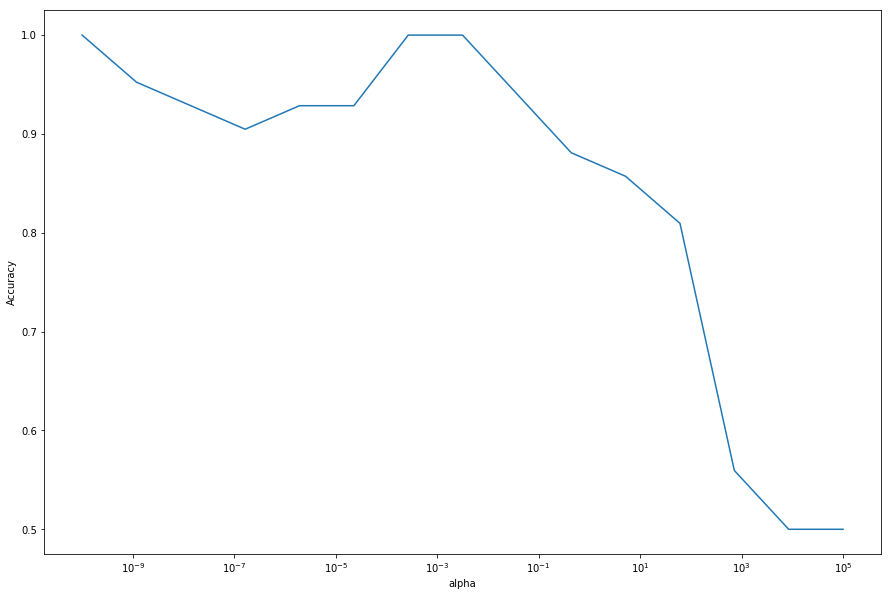

Best alpha:  1e-10
Theta found by sklearn:  [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  5.84327588e-06  0.00000000e+00
   0.00000000e+00 -1.43972452e-02 -1.09580910e-02  9.24257843e-04
  -7.58105955e-03  1.36451703e-03  6.63119968e-03  5.56274118e-04
   5.52439549e-06  2.92163794e-06  4.81080922e-04  4.06676792e-02
   0.00000000e+00  0.00000000e+00 -6.17515684e-04  5.25099261e-04
   2.62749584e-02  3.70370722e-05  0.00000000e+00  1.50740884e-03
  -4.75196999e-02 -2.80173034e-03  7.74875183e-03  3.75928365e-03
  -3.50793573e-02  1.00867486e-02  9.90670458e-03 -9.75754950e-02
  -7.44471899e-03]] [-0.0006883]
Training set acc: 1.0
[[16  0]
 [ 0 16]]
Specificity: 1.0
Sensitivity: 1.0
Train AUC: 1.0
[[59  5]
 [ 0  2]]
Specificity: 0.921875
Sensitivity: 1.0
Test set acc: 0.9242424242424242
Test AUC: 1.0


In [715]:
# Getting the training and test sets
rb_X = rb_data_clean.drop(columns=['is_hof', 'Indct'])
# 'team','college','high_school'
rb_X = rb_X.drop(columns=['name','age','year','end_year','position','years_played']).set_index('player_id')
rb_y = rb_data_clean.set_index('player_id')['is_hof']

#rbX_train, rbX_test, rby_train, rby_test = train_test_split(rb_X, rb_y, test_size=0.4)
#rbX_hof = 

rb_HOF = shuffle(rb_data_clean[rb_data_clean['is_hof']==1])
rb_HOFn = shuffle(rb_data_clean[rb_data_clean['is_hof']==0])

# 18/ 652 rbs are HOF. About 2.7% population
rb_hof_train = rb_HOF.head(16)
rb_hof_test = rb_HOF.tail(2)
rb_train = shuffle(pd.concat([rb_hof_train, rb_HOFn.head(16)]))
rb_test = shuffle(pd.concat([rb_hof_test, rb_HOFn.tail(64)])) # the 2 test rbs are 2.7% of 66 so: (66 - 2)

rbX_train = rb_train.drop(columns=['name','age','year','end_year','position','years_played','is_hof', 'Indct']).set_index('player_id')
rby_train = rb_train.set_index('player_id')['is_hof']

rbX_test = rb_test.drop(columns=['name','age','year','end_year','position','years_played','is_hof', 'Indct']).set_index('player_id')
rby_test = rb_test.set_index('player_id')['is_hof']


n_alphas = 15
alphas = np.logspace(-10, 5, n_alphas)
scores = []

for alpha in alphas:
    logreg = linear_model.LogisticRegression(C=1.0/alpha,solver='liblinear',fit_intercept=True, penalty='l1')
    logreg.fit(rbX_train, rby_train)
    score = cross_val_score(logreg, rbX_train, rby_train,
                             scoring='accuracy', cv=7)
    scores.append(np.mean(score))

score_dict = zip(alphas, scores)
max_pair = max(score_dict,key=lambda item:item[1])
plt.semilogx(alphas,scores)
plt.xlabel('alpha')
plt.ylabel('Accuracy')
plt.show()

alpha = max_pair[0]
print("Best alpha: ", alpha)

logreg = linear_model.LogisticRegression(C=1.0/alpha,solver='liblinear',fit_intercept=True)
logreg.fit(rbX_train, rby_train)
print("Theta found by sklearn: ", logreg.coef_, logreg.intercept_)




y_pred_discrete = logreg.predict(rbX_train)
print ('Training set acc: ' + str(accuracy_score(rby_train, y_pred_discrete)))
cm = confusion_matrix(rby_train, y_pred_discrete)
print(cm)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
print ('Specificity: ' + str(specificity))
print ('Sensitivity: ' + str(sensitivity))
y_pred = logreg.predict_proba(rbX_train)
print ('Train AUC: ' + str(roc_auc_score(rby_train, y_pred[:,1])))


y_pred_discrete = logreg.predict(rbX_test)
cm = confusion_matrix(rby_test, y_pred_discrete)
print(cm)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
print ('Specificity: ' + str(specificity))
print ('Sensitivity: ' + str(sensitivity))
y_pred = logreg.predict_proba(rbX_test)
print ('Test set acc: ' + str(accuracy_score(rby_test, y_pred_discrete)))
print ('Test AUC: ' + str(roc_auc_score(rby_test, y_pred[:,1])))




### WR model

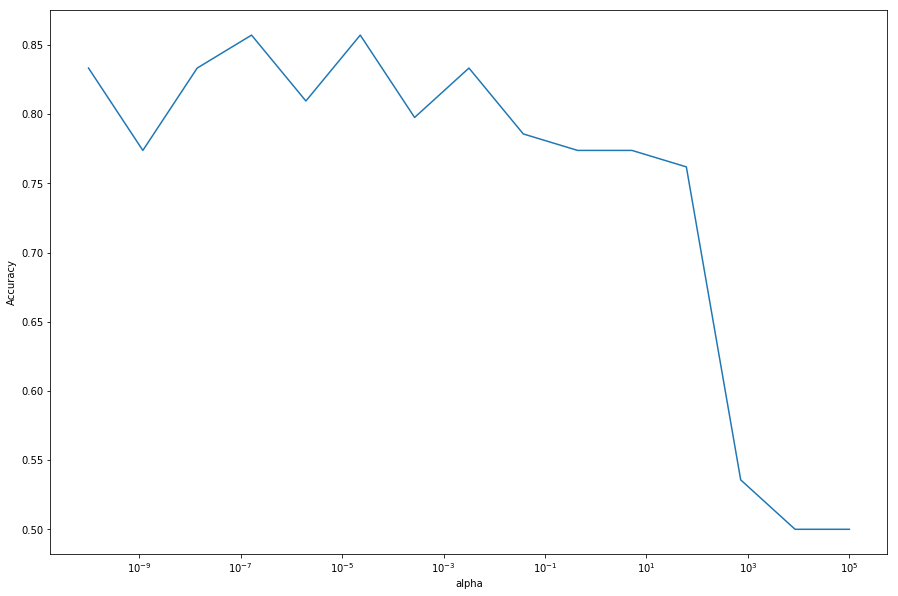

Best alpha:  1.6378937069540646e-07
Theta found by sklearn:  [[ 0.00000000e+00 -3.05776247e-03 -1.79868381e-04  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.80100761e-03 -1.53337795e-02
  -8.13904422e-03 -4.83373395e-01  9.46932881e-03  4.02510351e-03
  -5.76454645e-02 -9.01351530e-04 -1.46917346e-01 -1.92806846e-04
   0.00000000e+00  0.00000000e+00  4.18085519e-05  3.01611832e-01
  -1.55136478e-02 -1.60082859e-02 -9.64832126e-01 -1.32946375e-02
   1.12279826e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -6.71183002e-02 -5.71150832e-03  2.14621556e-01  9.97035159e-03
   2.03504578e-03  1.74203993e-02 -1.95092302e-02 -1.18600141e-01
   1.51117638e-02]] [-0.10288838]
Training set acc: 1.0
[[18  0]
 [ 0 18]]
Specificity: 1.0
Sensitivity: 1.0
Train AUC: 1.0
[[54 10]
 [ 0  2]]
Specificity: 0.84375
Sensitivity: 1.0
Test set acc: 0.8484848484848485
Test AUC: 0.9296875


In [718]:
# Getting the training and test sets
wr_X = wr_data_clean.drop(columns=['is_hof', 'Indct'])
# 'team','college','high_school'
wr_X = wr_X.drop(columns=['name','age','year','end_year','position','years_played']).set_index('player_id')
wr_y = wr_data_clean.set_index('player_id')['is_hof']

#wrX_train, wrX_test, wry_train, wry_test = train_test_split(wr_X, wr_y, test_size=0.4)
#wrX_hof = 

wr_HOF = shuffle(wr_data_clean[wr_data_clean['is_hof']==1])
wr_HOFn = shuffle(wr_data_clean[wr_data_clean['is_hof']==0])

# 20/ 667 wrs are HOF. About 2.9% population
# 667 total, 20 HOF (2.9 percent), 
wr_hof_train = wr_HOF.head(18)
wr_hof_test = wr_HOF.tail(2)
wr_train = shuffle(pd.concat([wr_hof_train, wr_HOFn.head(18)]))
wr_test = shuffle(pd.concat([wr_hof_test, wr_HOFn.tail(64)])) # the 2 test wrs are 2.9% of 60 so: (60 - 3)

wrX_train = wr_train.drop(columns=['name','age','year','end_year','position','years_played','is_hof', 'Indct']).set_index('player_id')
wry_train = wr_train.set_index('player_id')['is_hof']

wrX_test = wr_test.drop(columns=['name','age','year','end_year','position','years_played','is_hof', 'Indct']).set_index('player_id')
wry_test = wr_test.set_index('player_id')['is_hof']


n_alphas = 15
alphas = np.logspace(-10, 5, n_alphas)
scores = []

for alpha in alphas:
    logreg = linear_model.LogisticRegression(C=1.0/alpha,solver='liblinear',fit_intercept=True, penalty='l1')
    logreg.fit(wrX_train, wry_train)
    score = cross_val_score(logreg, wrX_train, wry_train,
                             scoring='accuracy', cv=7)
    scores.append(np.mean(score))

score_dict = zip(alphas, scores)
max_pair = max(score_dict,key=lambda item:item[1])
plt.semilogx(alphas,scores)
plt.xlabel('alpha')
plt.ylabel('Accuracy')
plt.show()

alpha = max_pair[0]
print("Best alpha: ", alpha)

logreg = linear_model.LogisticRegression(C=1.0/alpha,solver='liblinear',fit_intercept=True)
logreg.fit(wrX_train, wry_train)
print("Theta found by sklearn: ", logreg.coef_, logreg.intercept_)




y_pred_discrete = logreg.predict(wrX_train)
print ('Training set acc: ' + str(accuracy_score(wry_train, y_pred_discrete)))
cm = confusion_matrix(wry_train, y_pred_discrete)
print(cm)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
print ('Specificity: ' + str(specificity))
print ('Sensitivity: ' + str(sensitivity))
y_pred = logreg.predict_proba(wrX_train)
print ('Train AUC: ' + str(roc_auc_score(wry_train, y_pred[:,1])))


y_pred_discrete = logreg.predict(wrX_test)
cm = confusion_matrix(wry_test, y_pred_discrete)
print(cm)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
print ('Specificity: ' + str(specificity))
print ('Sensitivity: ' + str(sensitivity))
y_pred = logreg.predict_proba(wrX_test)
print ('Test set acc: ' + str(accuracy_score(wry_test, y_pred_discrete)))
print ('Test AUC: ' + str(roc_auc_score(wry_test, y_pred[:,1])))




## Testing the WR model on the three WR 2019 Nominees

In [719]:
y_pred_discrete = logreg.predict(noms_id)
y_pred_discrete

array([1, 1, 0])

## Experimenting with Feed Forward Neural Nets

## QB Feed Forward Network

In [726]:
# Getting the training and test sets
qb_X = qb_data_clean.drop(columns=['is_hof', 'Indct'])
# 'team','college','high_school'
qb_X = qb_X.drop(columns=['name','age','year','end_year','position','years_played']).set_index('player_id')
qb_y = qb_data_clean.set_index('player_id')['is_hof']

#qbX_train, qbX_test, qby_train, qby_test = train_test_split(qb_X, qb_y, test_size=0.4)
#qbX_hof = 

qb_HOF = shuffle(qb_data_clean[qb_data_clean['is_hof']==1])
qb_HOFn = shuffle(qb_data_clean[qb_data_clean['is_hof']==0])

# 17/ 338 QBs are HOF. About 5% population
qb_hof_train = qb_HOF.head(14)
qb_hof_test = qb_HOF.tail(3)
qb_train = shuffle(pd.concat([qb_hof_train, qb_HOFn.head(14)]))
qb_test = shuffle(pd.concat([qb_hof_test, qb_HOFn.tail(57)])) # the 3 test QBs are 5% of 60 so: (60 - 3)

qbX_train = qb_train.drop(columns=['name','age','year','end_year','position','years_played','is_hof', 'Indct']).set_index('player_id')
qby_train = qb_train.set_index('player_id')['is_hof']

qbX_test = qb_test.drop(columns=['name','age','year','end_year','position','years_played','is_hof', 'Indct']).set_index('player_id')
qby_test = qb_test.set_index('player_id')['is_hof']

nb_classes = 2
qby_train = np_utils.to_categorical(qby_train, nb_classes)
qby_test = np_utils.to_categorical(qby_test, nb_classes)

Train on 28 samples, validate on 60 samples
Epoch 1/6
28/28 [==============================] - 3s 94ms/step - loss: 6.9768 - acc: 0.5357 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2/6
28/28 [==============================] - 0s 203us/step - loss: 7.4834 - acc: 0.5357 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3/6
28/28 [==============================] - 0s 217us/step - loss: 8.0590 - acc: 0.5000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4/6
28/28 [==============================] - 0s 232us/step - loss: 8.0590 - acc: 0.5000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 5/6
28/28 [==============================] - 0s 216us/step - loss: 8.0590 - acc: 0.5000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 6/6
28/28 [==============================] - 0s 219us/step - loss: 8.0590 - acc: 0.5000 - val_loss: 0.8059 - val_acc: 0.9500
Test loss: 0.8059048056602478
Test accuracy: 0.950000007947286


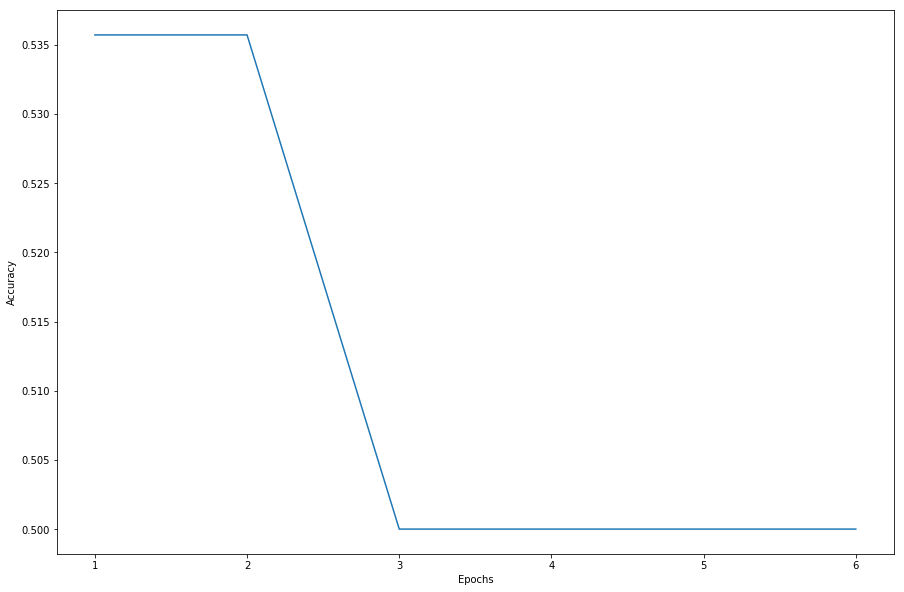

In [727]:
shape = 37
ep_num = 6

model1 = Sequential()

model1.add(Dense(512, input_shape=(shape,)))
model1.add(Activation('relu'))
model1.add(Dropout(0.2)) 

model1.add(Dense(nb_classes))
model1.add(Activation('softmax')) 

model1.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

history = AccuracyHistory()

model1.fit(qbX_train, qby_train,
          batch_size=128, epochs=ep_num,
          verbose=1,validation_data=(qbX_test, qby_test),
          callbacks=[history])
# plot scores
score1 = model1.evaluate(qbX_test, qby_test, verbose=0)
print('Test loss:', score1[0])
print('Test accuracy:', score1[1])
plt.plot(range(1, ep_num + 1), history.acc)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()


## RB Feed Forward Network

Train on 28 samples, validate on 60 samples
Epoch 1/6
28/28 [==============================] - 2s 82ms/step - loss: 8.6347 - acc: 0.4643 - val_loss: 1.1759 - val_acc: 0.9167
Epoch 2/6
28/28 [==============================] - 0s 210us/step - loss: 6.9078 - acc: 0.5714 - val_loss: 1.1759 - val_acc: 0.9167
Epoch 3/6
28/28 [==============================] - 0s 231us/step - loss: 7.6540 - acc: 0.5000 - val_loss: 1.0745 - val_acc: 0.9333
Epoch 4/6
28/28 [==============================] - 0s 218us/step - loss: 8.0590 - acc: 0.5000 - val_loss: 1.0745 - val_acc: 0.9333
Epoch 5/6
28/28 [==============================] - 0s 213us/step - loss: 7.4834 - acc: 0.5357 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 6/6
28/28 [==============================] - 0s 240us/step - loss: 7.4834 - acc: 0.5357 - val_loss: 0.8059 - val_acc: 0.9500
Test loss: 0.8059048175811767
Test accuracy: 0.949999988079071


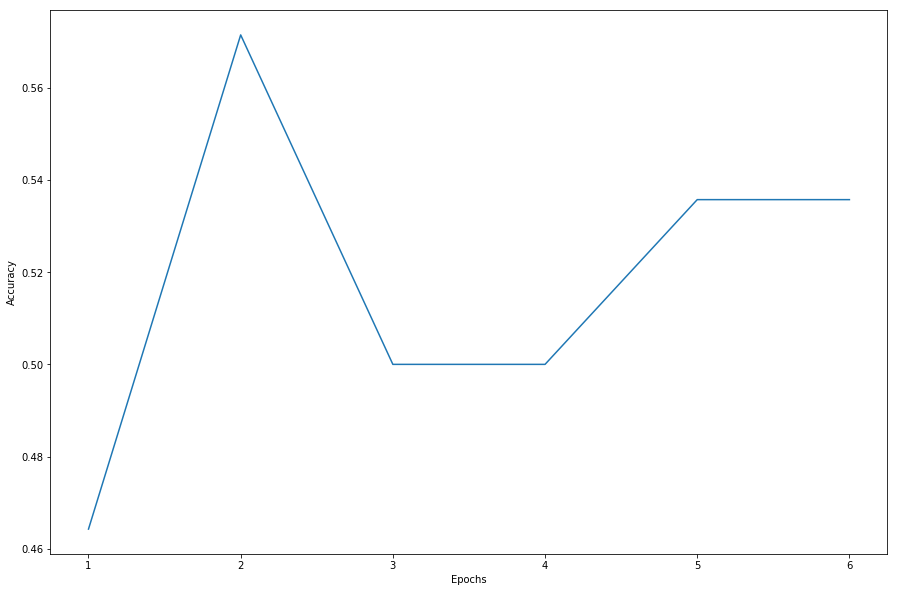

In [728]:
# Getting the training and test sets
rb_X = rb_data_clean.drop(columns=['is_hof', 'Indct'])
# 'team','college','high_school'
rb_X = rb_X.drop(columns=['name','age','year','end_year','position','years_played']).set_index('player_id')
rb_y = rb_data_clean.set_index('player_id')['is_hof']

#rbX_train, rbX_test, rby_train, rby_test = train_test_split(rb_X, rb_y, test_size=0.4)
#rbX_hof = 

rb_HOF = shuffle(rb_data_clean[rb_data_clean['is_hof']==1])
rb_HOFn = shuffle(rb_data_clean[rb_data_clean['is_hof']==0])

# 17/ 338 rbs are HOF. About 5% population
rb_hof_train = rb_HOF.head(14)
rb_hof_test = rb_HOF.tail(3)
rb_train = shuffle(pd.concat([rb_hof_train, rb_HOFn.head(14)]))
rb_test = shuffle(pd.concat([rb_hof_test, rb_HOFn.tail(57)])) # the 3 test rbs are 5% of 60 so: (60 - 3)

rbX_train = rb_train.drop(columns=['name','age','year','end_year','position','years_played','is_hof', 'Indct']).set_index('player_id')
rby_train = rb_train.set_index('player_id')['is_hof']

rbX_test = rb_test.drop(columns=['name','age','year','end_year','position','years_played','is_hof', 'Indct']).set_index('player_id')
rby_test = rb_test.set_index('player_id')['is_hof']
nb_classes = 2
rby_train = np_utils.to_categorical(rby_train, nb_classes)
rby_test = np_utils.to_categorical(rby_test, nb_classes)

shape = 37
ep_num = 6

model1 = Sequential()

model1.add(Dense(512, input_shape=(shape,)))
model1.add(Activation('relu'))
model1.add(Dropout(0.2)) 

model1.add(Dense(nb_classes))
model1.add(Activation('softmax')) 

model1.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

history = AccuracyHistory()

model1.fit(rbX_train, rby_train,
          batch_size=128, epochs=ep_num,
          verbose=1,validation_data=(rbX_test, rby_test),
          callbacks=[history])
# plot scores
score1 = model1.evaluate(rbX_test, rby_test, verbose=0)
print('Test loss:', score1[0])
print('Test accuracy:', score1[1])
plt.plot(range(1, ep_num + 1), history.acc)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()


## WR Feed Forward Networks

Train on 28 samples, validate on 60 samples
Epoch 1/6
28/28 [==============================] - 7s 254ms/step - loss: 8.0590 - acc: 0.5000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 2/6
28/28 [==============================] - 0s 628us/step - loss: 8.0590 - acc: 0.5000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 3/6
28/28 [==============================] - 0s 694us/step - loss: 8.6347 - acc: 0.4643 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 4/6
28/28 [==============================] - 0s 703us/step - loss: 7.4834 - acc: 0.5357 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 5/6
28/28 [==============================] - 0s 633us/step - loss: 7.6055 - acc: 0.5000 - val_loss: 0.8059 - val_acc: 0.9500
Epoch 6/6
28/28 [==============================] - 0s 1ms/step - loss: 8.0590 - acc: 0.5000 - val_loss: 0.8059 - val_acc: 0.9500
Test loss: 0.8059048056602478
Test accuracy: 0.950000007947286


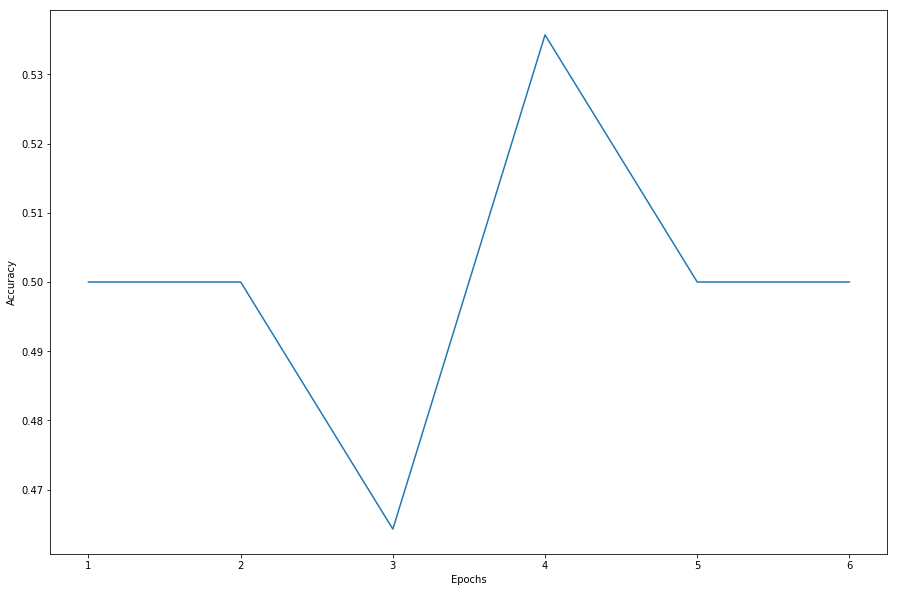

In [769]:
# Getting the training and test sets
wr_X = wr_data_clean.drop(columns=['is_hof', 'Indct'])
# 'team','college','high_school'
wr_X = wr_X.drop(columns=['name','age','year','end_year','position','years_played']).set_index('player_id')
wr_y = wr_data_clean.set_index('player_id')['is_hof']

#wrX_train, wrX_test, wry_train, wry_test = train_test_split(wr_X, wr_y, test_size=0.4)
#wrX_hof = 

wr_HOF = shuffle(wr_data_clean[wr_data_clean['is_hof']==1])
wr_HOFn = shuffle(wr_data_clean[wr_data_clean['is_hof']==0])

# 17/ 338 wrs are HOF. About 5% population
wr_hof_train = wr_HOF.head(14)
wr_hof_test = wr_HOF.tail(3)
wr_train = shuffle(pd.concat([wr_hof_train, wr_HOFn.head(14)]))
wr_test = shuffle(pd.concat([wr_hof_test, wr_HOFn.tail(57)])) # the 3 test wrs are 5% of 60 so: (60 - 3)

wrX_train = wr_train.drop(columns=['name','age','year','end_year','position','years_played','is_hof', 'Indct']).set_index('player_id')
wry_train = wr_train.set_index('player_id')['is_hof']

wrX_test = wr_test.drop(columns=['name','age','year','end_year','position','years_played','is_hof', 'Indct']).set_index('player_id')
wry_test = wr_test.set_index('player_id')['is_hof']
nb_classes = 2
wry_train = np_utils.to_categorical(wry_train, nb_classes)
wry_test = np_utils.to_categorical(wry_test, nb_classes)

shape = 37
ep_num = 6

model1 = Sequential()

model1.add(Dense(512, input_shape=(shape,)))
model1.add(Activation('relu'))
model1.add(Dropout(0.2)) 

model1.add(Dense(256))
model1.add(Activation('relu'))
model1.add(Dropout(0.2)) 


model1.add(Dense(nb_classes))
model1.add(Activation('softmax')) 

model1.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

history = AccuracyHistory()

model1.fit(wrX_train, wry_train,
          batch_size=128, epochs=ep_num,
          verbose=1,validation_data=(wrX_test, wry_test),
          callbacks=[history])
# plot scores
score1 = model1.evaluate(wrX_test, wry_test, verbose=0)
print('Test loss:', score1[0])
print('Test accuracy:', score1[1])
plt.plot(range(1, ep_num + 1), history.acc)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()


In [771]:
model1.predict(noms_id)

array([[1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

## Experimenting with decision trees

#### This is when we discovered our model never overfits regardless of depth and we found that weird. We wanted to look into it but ran out of time.

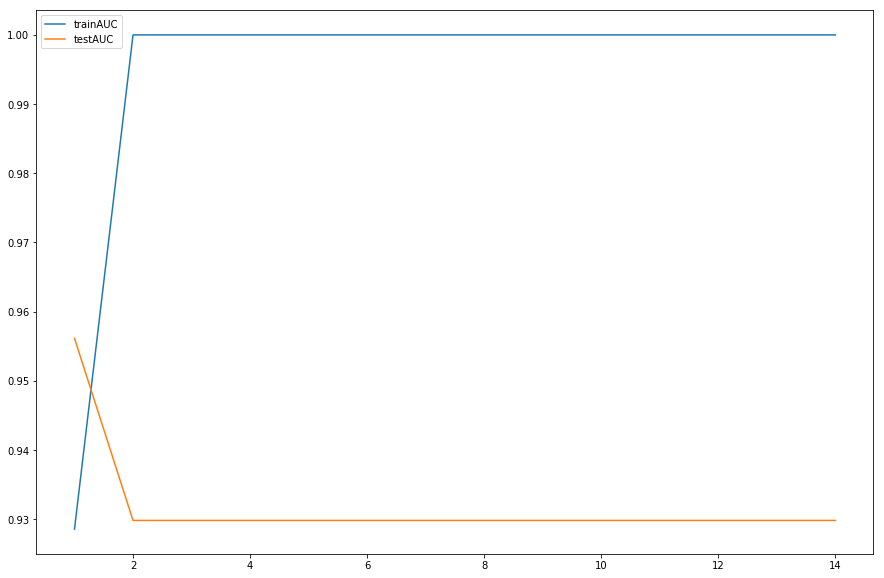

Test acc: 0.956140350877193


'dtree_render.png'

In [768]:
# Getting the training and test sets
qb_X = qb_data_clean.drop(columns=['is_hof', 'Indct'])
# 'team','college','high_school'
qb_X = qb_X.drop(columns=['name','age','year','end_year','position','years_played']).set_index('player_id')
qb_y = qb_data_clean.set_index('player_id')['is_hof']




#qbX_train, qbX_test, qby_train, qby_test = train_test_split(qb_X, qb_y, test_size=0.4)
#qbX_hof = 

qb_HOF = shuffle(qb_data_clean[qb_data_clean['is_hof']==1])
qb_HOFn = shuffle(qb_data_clean[qb_data_clean['is_hof']==0])

# 17/ 338 QBs are HOF. About 5% population
qb_hof_train = qb_HOF.head(14)
qb_hof_test = qb_HOF.tail(3)
qb_train = shuffle(pd.concat([qb_hof_train, qb_HOFn.head(14)]))
qb_test = shuffle(pd.concat([qb_hof_test, qb_HOFn.tail(57)])) # the 3 test QBs are 5% of 60 so: (60 - 3)

qbX_train = qb_train.drop(columns=['name','age','year','end_year','position','years_played','is_hof', 'Indct']).set_index('player_id')
qby_train = qb_train.set_index('player_id')['is_hof']

qbX_test = qb_test.drop(columns=['name','age','year','end_year','position','years_played','is_hof', 'Indct']).set_index('player_id')
qby_test = qb_test.set_index('player_id')['is_hof']




depthData = pd.DataFrame(columns=['trainAUC', 'testAUC'])
depths = np.arange(1,15)
trainAUCs = []
testAUCs = []

for depth in depths:
    clf = DecisionTreeClassifier(max_depth=depth)
    clf.fit(qbX_train, qby_train)
    ypredTest = clf.predict_proba(qbX_test)
    ypredTrain = clf.predict_proba(qbX_train)
    depthData.at[depth,'trainAUC'] = roc_auc_score(qby_train, ypredTrain[:,1])
    depthData.at[depth,'testAUC'] = roc_auc_score(qby_test, ypredTest[:,1])

depthData.plot(use_index=True)
plt.show()
new = depthData.columns[depthData.dtypes.eq(object)] #get the object column of the best_c
depthData[new] = depthData[new].apply(pd.to_numeric, errors = 'coerce', axis=0) # change the type of object

clf = DecisionTreeClassifier(max_depth=depthData['testAUC'].idxmax())
clf.fit(qbX_train, qby_train)
import graphviz
dot_data = sklearn.tree.export_graphviz(clf, out_file=None, 
                         feature_names=qbX_train.columns,  
                         filled=True,  
                         special_characters=True, 
                                        rotate=True)

ypredTest = clf.predict_proba(qbX_test)
print('Test acc: ' + str(roc_auc_score(qby_test, ypredTest[:,1])))
graph = graphviz.Source(dot_data)  
graph
graph.format = 'png'
graph.render('dtree_render',view=True)
